Start training...
Training completed!
Predicting on validation set...
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.82      0.85      1290
           1       0.71      0.81      0.76       710

    accuracy                           0.82      2000
   macro avg       0.80      0.82      0.81      2000
weighted avg       0.83      0.82      0.82      2000


ROC-AUC: 0.8906332569057758

Best F1-score: 0.767 at threshold 0.41


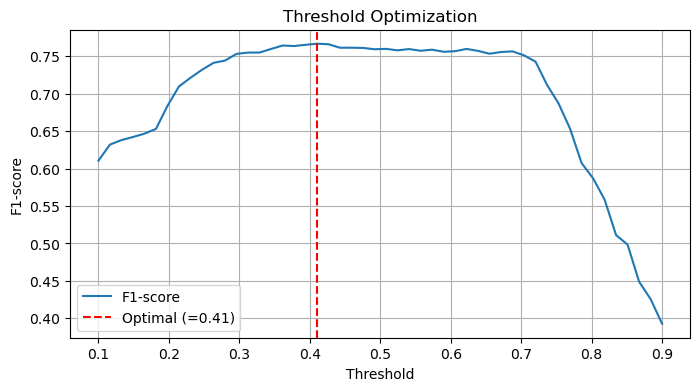


Metrics with optimal threshold:
              precision    recall  f1-score   support

           0       0.90      0.80      0.85      1290
           1       0.70      0.85      0.77       710

    accuracy                           0.82      2000
   macro avg       0.80      0.82      0.81      2000
weighted avg       0.83      0.82      0.82      2000



In [5]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, f1_score  # Добавили f1_score
import matplotlib.pyplot as plt


tr = pd.read_parquet('data/train.parquet')
tst = pd.read_parquet('data/test.parquet')

tr = tr.sample(10000, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    tr[['model_1', 'model_2', 'model_3', 'model_4', 'model_5']],
    tr['target'],
    test_size=0.2,
    random_state=42,
    stratify=tr['target']
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

logreg = LogisticRegression(
    penalty='l2',           # Регуляризация L2 (можно попробовать 'l1')
    C=1.0,                  # Параметр регуляризации (меньше C → сильнее регуляризация)
    class_weight='balanced', # Балансировка классов
    solver='lbfgs',         # Алгоритм оптимизации (для L2)
    max_iter=1000,          # Увеличиваем, если модель не сходится
    random_state=42
)

print('Start training...')
logreg.fit(X_train_scaled, y_train)
print('Training completed!')

# Предсказание на валидации
print('Predicting on validation set...')
y_val_pred = logreg.predict(X_val_scaled)
y_val_pred_proba = logreg.predict_proba(X_val_scaled)[:, 1]

# Оценка
print("Classification Report:")
print(classification_report(y_val, y_val_pred))
print("\nROC-AUC:", roc_auc_score(y_val, y_val_pred_proba))

# Подбор порога
thresholds = np.linspace(0.1, 0.9, 50)
f1_scores = [f1_score(y_val, (y_val_pred_proba >= t).astype(int)) for t in thresholds]
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"\nBest F1-score: {f1_scores[optimal_idx]:.3f} at threshold {optimal_threshold:.2f}")

# Визуализация
plt.figure(figsize=(8, 4))
plt.plot(thresholds, f1_scores, label='F1-score')
plt.axvline(optimal_threshold, color='r', linestyle='--', label=f'Optimal (={optimal_threshold:.2f})')
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.title("Threshold Optimization")
plt.legend()
plt.grid()
plt.show()

# Применение оптимального порога
y_val_pred_optimal = (y_val_pred_proba >= optimal_threshold).astype(int)
print("\nMetrics with optimal threshold:")
print(classification_report(y_val, y_val_pred_optimal))

In [2]:
# Обучение на всех тренировочных данных
scaler_full = StandardScaler()
X_full_scaled = scaler_full.fit_transform(tr[['model_1', 'model_2', 'model_5']])
y_full = tr['target']

# Инициализация и обучение модели
logreg_full = LogisticRegression(
    penalty='l2',
    C=1.0,
    class_weight='balanced',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)

print('Training on full dataset...')
logreg_full.fit(X_full_scaled, y_full)
print('Training completed!')

# Предсказание для теста
X_test_scaled = scaler_full.transform(tst[['model_1', 'model_2', 'model_5']])
y_test_pred_proba = logreg_full.predict_proba(X_test_scaled)[:, 1]

# Применение оптимального порога (0.51)
optimal_threshold = 0.51
y_test_pred = (y_test_pred_proba >= optimal_threshold).astype(int)

# Сохранение результатов
predictions = pd.DataFrame({
    'order_id': tst['order_id'],
    'predicted_probability': y_test_pred_proba,
    'predicted_class': y_test_pred
})

# Вывод распределения классов
print("\nPredicted class distribution in test set:")
print(predictions['predicted_class'].value_counts(normalize=True))

#predictions.to_csv('test_predictions_logreg.csv', index=False)


Training on full dataset...
Training completed!

Predicted class distribution in test set:
predicted_class
0    0.624855
1    0.375145
Name: proportion, dtype: float64


In [4]:
predictions[['order_id', 'predicted_class']].to_csv('simple_logreg_51_1, 2, 5.csv', index=False)